In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

import gc


In [3]:
#Load insertion site dataframe
insertions_file = '/home/drk/hic/data/trip/Dataset_S2_TRIP.tsv'
insertions_df = pd.read_csv(insertions_file, sep='\t')

insertions_df['row_index'] = np.arange(len(insertions_df), dtype='int32')

print("len(insertions_df) = " + str(len(insertions_df)))

#Filter sites that are too close to chromosome edges
min_flank_len = 131072

genome_len_df = pd.read_csv('/home/drk/common/data/genomes/hg38/assembly/ucsc/hg38.human.genome', names=['chrom', 'chrom_len'], sep='\t')
genome_len_df = genome_len_df.drop_duplicates(subset=['chrom'], keep='first').copy().reset_index(drop=True)

#Augment with chromosome lengths and find rows to close to edges
insertions_df = insertions_df.join(genome_len_df.set_index('chrom'), on='seqname', how='inner').sort_values(by=['row_index'], ascending=True).copy().reset_index(drop=True)
insertions_df['valid_flank'] = insertions_df.apply(lambda row: (row['position'] >= min_flank_len and row['chrom_len'] - row['position'] >= min_flank_len), axis=1)

#Filter dataframe
keep_index = np.nonzero(np.array((insertions_df['valid_flank'] & (~insertions_df.LMNB1_DamID.isnull())).values))[0]
insertions_df = insertions_df.iloc[keep_index].copy().reset_index(drop=True)

print("len(insertions_df) = " + str(len(insertions_df)) + " (after filtering)")


len(insertions_df) = 12812
len(insertions_df) = 12777 (after filtering)


In [4]:
#Load predicted coverage track and crop to reasonable lengths (64 kb)

#Crop length per side
crop_len = 7152

#Number of folds
n_folds = 4

#List to accumualte fold predictions
preds = []

#Loop over folds
for fold_ix in range(n_folds) :
    
    print("fold_ix = " + str(fold_ix))
    
    #Load and crop predictions
    preds_h5 = h5py.File('test_trip/f' + str(fold_ix) + 'c0/trip/preds.h5')
    preds_fold = preds_h5['preds'][()][:, crop_len:-crop_len, :]
    preds_h5.close()
    
    #Append fold predictions
    preds.append(preds_fold[:, None, ...].astype('float32'))
    
    #Collect garbage
    gc.collect()

#Concatenate predictions
preds = np.concatenate(preds, axis=1)

#Filter out rows that had been removed in previous step (insertion dataframe filtering)
preds = preds[keep_index, ...]

print("preds.shape = " + str(preds.shape))


fold_ix = 0
fold_ix = 1
fold_ix = 2
fold_ix = 3
preds.shape = (12777, 4, 2048, 46)


In [5]:
#Load target file

targets_df = pd.read_csv('targets_k562.txt', sep='\t')

#Determine strandness of track
targets_df['strand'] = targets_df.apply(lambda row: row['identifier'][-1] if row['identifier'][-1] in ['+', '-'] else '.', axis=1)

#Optionally undo transformations (negligible and inconsistent performance differences)
undo_transforms = True

if undo_transforms :
    
    #Get transform parameters from target file
    scales = np.array(targets_df['scale'].values)[None, None, None, :]
    clip_softs = np.array(targets_df['clip_soft'].values)[None, None, None, :]
    track_transforms = np.array(targets_df['sum_stat'].apply(lambda x: 3./4. if x == 'sum_sqrt' else 1.).values)[None, None, None, :]

    #Undo scale
    preds /= scales

    #Undo clip_soft
    preds_unclipped = (preds - clip_softs)**2 + clip_softs
    unclip_mask = (preds > clip_softs)

    preds[unclip_mask] = preds_unclipped[unclip_mask]

    #Undo sqrt
    preds = preds**(1. / track_transforms)


In [6]:
#Split coverage tracks into assay-specific average tracks

#CAGE
cage_mask = np.array([row['description'].startswith('CAGE:') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_cage = preds[...,cage_mask].mean(axis=-1)
print("preds_cage.shape = " + str(preds_cage.shape))

#DNase
dnase_mask = np.array([row['description'].startswith('DNASE:') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_dnase = preds[...,dnase_mask].mean(axis=-1)
print("preds_dnase.shape = " + str(preds_dnase.shape))

#H3K4me3
h3k4me3_mask = np.array([row['description'].startswith('CHIP:H3K4me3') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_h3k4me3 = preds[...,h3k4me3_mask].mean(axis=-1)
print("preds_h3k4me3.shape = " + str(preds_h3k4me3.shape))

#H3K9ac
h3k9ac_mask = np.array([row['description'].startswith('CHIP:H3K9ac') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_h3k9ac = preds[...,h3k9ac_mask].mean(axis=-1)
print("preds_h3k9ac.shape = " + str(preds_h3k9ac.shape))

#H3K36me3
h3k36me3_mask = np.array([row['description'].startswith('CHIP:H3K36me3') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_h3k36me3 = preds[...,h3k36me3_mask].mean(axis=-1)
print("preds_h3k36me3.shape = " + str(preds_h3k36me3.shape))

#H3K79me2
h3k79me2_mask = np.array([row['description'].startswith('CHIP:H3K79me') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_h3k79me2 = preds[...,h3k79me2_mask].mean(axis=-1)
print("preds_h3k79me2.shape = " + str(preds_h3k79me2.shape))

#H3K9me3
h3k9me3_mask = np.array([row['description'].startswith('CHIP:H3K9me3') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_h3k9me3 = preds[...,h3k9me3_mask].mean(axis=-1)
print("preds_h3k9me3.shape = " + str(preds_h3k9me3.shape))

#H3K27me3
h3k27me3_mask = np.array([row['description'].startswith('CHIP:H3K27me3') and row['strand'] != '-' for _, row in targets_df.iterrows()], dtype='bool')
preds_h3k27me3 = preds[...,h3k27me3_mask].mean(axis=-1)
print("preds_h3k27me3.shape = " + str(preds_h3k27me3.shape))


preds_dnase.shape = (12777, 4, 2048)
preds_h3k4me3.shape = (12777, 4, 2048)
preds_h3k9ac.shape = (12777, 4, 2048)
preds_h3k36me3.shape = (12777, 4, 2048)
preds_h3k79me2.shape = (12777, 4, 2048)
preds_h3k9me3.shape = (12777, 4, 2048)
preds_h3k27me3.shape = (12777, 4, 2048)


In [7]:
#Organize rows by distinct promoter

#Get promoters
promoters = sorted(set(insertions_df.promoter))
print("promoters = " + str(promoters))

#Get promoter-specific row masks 
promoters_mask = {}
promoters_df = {}
for promoter in promoters:
    
    #Find rows belonging to promoter
    promoters_mask[promoter] = (insertions_df.promoter == promoter)
    promoters_df[promoter] = insertions_df[promoters_mask[promoter]]
    
    print(promoter + ", # = " + str(promoters_df[promoter].shape[0]))

promoter_colors = [
    '#f01d1d',
    '#e50046',
    '#ce0065',
    '#ae197a',
    '#863085',
    '#5d3a84',
    '#353d79',
]


promoters = ['ADAMTS1', 'ARHGEF9', 'BRINP1', 'MED30', 'TMEM106B', 'ZNF300', 'hPGK']
ADAMTS1, # = 676
ARHGEF9, # = 2558
BRINP1, # = 1550
MED30, # = 2172
TMEM106B, # = 628
ZNF300, # = 1689
hPGK, # = 3504


In [56]:
#Calculate center positions per assay from average signal profile

promoter_center = {}

#Average CAGE signal across folds
preds_cage_mean = np.mean(preds_cage, axis=1)

#Loop over distinct promoters
for promoter in promoters :
    
    #Calculate average signal for promoter
    prom_mask = promoters_mask[promoter]
    prom_preds = np.log1p(preds_cage_mean[prom_mask, ...])
    prom_preds = prom_preds.mean(axis=0)
    
    #Get maximum three positions
    prom_max3 = np.argsort(prom_preds)[::-1][:3]
    
    #Store average position
    prom_left, prom_right = prom_max3.min(), prom_max3.max()
    promoter_center[promoter] = (prom_right + prom_left) // 2

print("promoter_center = " + str(promoter_center))


promoter_center = {'ADAMTS1': 1032, 'ARHGEF9': 1042, 'BRINP1': 1029, 'MED30': 1040, 'TMEM106B': 1038, 'ZNF300': 1044, 'hPGK': 1029}


In [67]:
from matplotlib.ticker import FormatStrFormatter

#Function to plot correlation between aggregation of predicted coverage signal and measured expression
def plot_preds_corr(preds_sub_folds, agg_mode='sum_log', save_figs=False, fig_suffix='_default', neg=False) :
    
    #Rows and columns for promoter types
    nrows, ncols = 4, 2
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12,6))
    
    #Get average coverage track across folds
    preds_sub = np.mean(preds_sub_folds, axis=1)
    
    #Dictionary to store best aggregation windows per promoter
    promoter_ext = {}
    
    ext_rs = []

    #Loop over promoters
    pi = 0
    for ri in range(nrows) :
        for ci in range(ncols) :
            if pi < len(promoters) :
                
                #Get promoter masks, midpoints and measured expression values
                prom_mask = promoters_mask[promoters[pi]]
                prom_mid = promoter_center[promoters[pi]]
                
                prom_expr = None
                if 'log' in agg_mode :
                    prom_expr = np.log(promoters_df[promoters[pi]].expression.values + 1e-6)
                elif 'log1p' in agg_mode :
                    prom_expr = np.log1p(promoters_df[promoters[pi]].expression.values)

                #Calculate pearson correlation as a function of aggregation window size
                ext_r = []
                for ext in range(preds_sub.shape[1]//8) :
                    
                    prom_preds = None
                    if agg_mode == 'sum_log' :
                        prom_preds = np.log(preds_sub[prom_mask,prom_mid-ext:prom_mid+1+ext].sum(axis=1) + 1e-6)
                    elif agg_mode == 'log_mean' :
                        prom_preds = np.log(preds_sub[prom_mask,prom_mid-ext:prom_mid+1+ext] + 1e-6).mean(axis=1)
                    elif agg_mode == 'sum_log1p' :
                        prom_preds = np.log1p(preds_sub[prom_mask,prom_mid-ext:prom_mid+1+ext].sum(axis=1))
                    elif agg_mode == 'log1p_mean' :
                        prom_preds = np.log1p(preds_sub[prom_mask,prom_mid-ext:prom_mid+1+ext]).mean(axis=1)
                    
                    #Calculate and store correlation metric
                    pr = spearmanr(prom_preds, prom_expr)[0]
                    ext_r.append(pr)
                
                #Optionally negate correlation metrics
                if neg:
                    best_pr = np.min(ext_r)
                    promoter_ext[promoters[pi]] = np.argmin(ext_r)
                else:
                    best_pr = np.max(ext_r)
                    promoter_ext[promoters[pi]] = np.argmax(ext_r)

                axs[ri,ci].plot(ext_r, linewidth=0.75, color=promoter_colors[pi], linestyle='-')
                axs[ri,ci].axvline(promoter_ext[promoters[pi]], linewidth=0.75, linestyle='--', c='gold')
                
                plt.sca(axs[ri,ci])
                plt.xlim(0, 256)
                
                plt.xticks([0, 64, 128, 256], [0, 4096, 8192, 16384], fontsize=8)
                plt.yticks(fontsize=8)
                
                plt.xlabel("Window Size (bp)", fontsize=8)
                plt.ylabel("Spearman R", fontsize=8)
                
                plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                
                plt.title(promoters[pi] + ", R = " + str(round(best_pr, 3)), fontsize=8)
                
                print("-- " + promoters[pi] + " --")
                print(" - Optimal window size = " + str(int(promoter_ext[promoters[pi]] * 2 * 32)))
                print(" - Spearman R at 4kb = " + str(round(ext_r[64], 3)))
                print(" - Spearman R at 8kb = " + str(round(ext_r[128], 3)))
                print("")
                
                ext_rs.append(np.array(ext_r)[None, :])
            
            else :
                plt.sca(axs[ri,ci])
                plt.axis('off')
            
            pi += 1

    plt.tight_layout()
    
    if save_figs :
        plt.savefig("TRIP_v2_window_corr" + fig_suffix + ".png", dpi=600, transparent=False)
        plt.savefig("TRIP_v2_window_corr" + fig_suffix + ".eps")
    
    plt.show()
    
    print("-- Average --")
    
    ext_r = np.mean(np.concatenate(ext_rs, axis=0), axis=0)
    
    print(" - Optimal window size = " + str(int(np.mean(list(promoter_ext.values())) * 2 * 32)))
    print(" - Spearman R at 4kb = " + str(round(ext_r[64], 3)))
    print(" - Spearman R at 8kb = " + str(round(ext_r[128], 3)))
    
    return promoter_ext


-- ADAMTS1 --
 - Optimal window size = 128
 - Spearman R at 4kb = 0.571
 - Spearman R at 8kb = 0.567

-- ARHGEF9 --
 - Optimal window size = 15104
 - Spearman R at 4kb = 0.568
 - Spearman R at 8kb = 0.578

-- BRINP1 --
 - Optimal window size = 3456
 - Spearman R at 4kb = 0.564
 - Spearman R at 8kb = 0.553

-- MED30 --
 - Optimal window size = 15872
 - Spearman R at 4kb = 0.524
 - Spearman R at 8kb = 0.551

-- TMEM106B --
 - Optimal window size = 8064
 - Spearman R at 4kb = 0.551
 - Spearman R at 8kb = 0.567

-- ZNF300 --
 - Optimal window size = 16320
 - Spearman R at 4kb = 0.536
 - Spearman R at 8kb = 0.56

-- hPGK --
 - Optimal window size = 16064
 - Spearman R at 4kb = 0.324
 - Spearman R at 8kb = 0.338



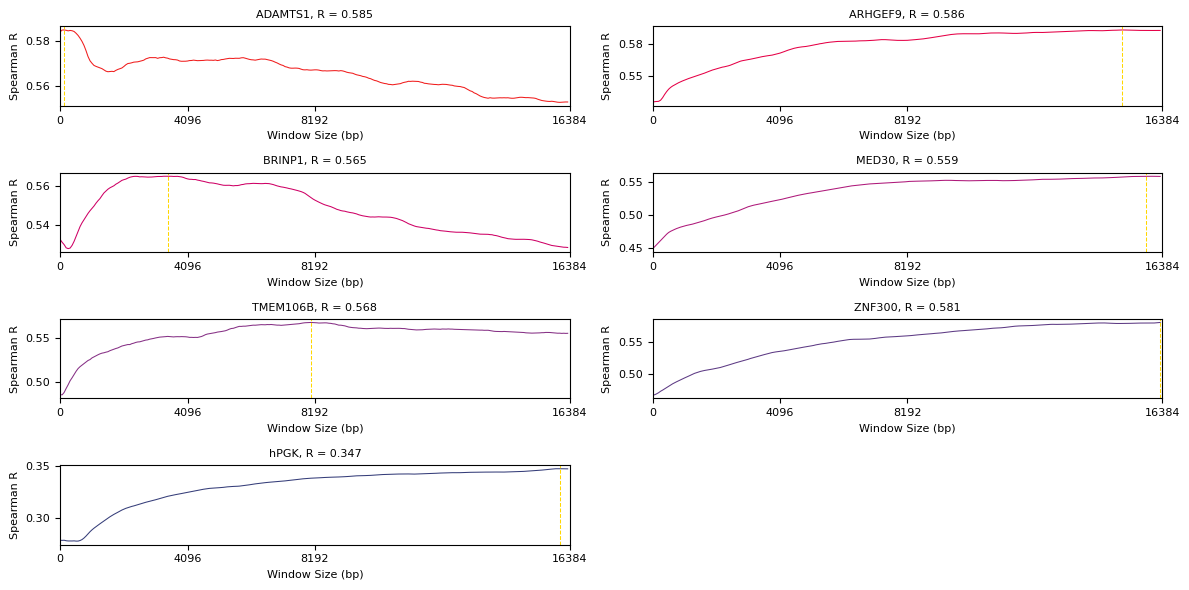

-- Average --
 - Optimal window size = 10715
 - Spearman R at 4kb = 0.52
 - Spearman R at 8kb = 0.531


In [68]:
#Make plots for DNase window correlations
_ = plot_preds_corr(preds_dnase, agg_mode='sum_log', save_figs=True, fig_suffix='_DNASE_v3')


-- ADAMTS1 --
 - Optimal window size = 6272
 - Spearman R at 4kb = 0.561
 - Spearman R at 8kb = 0.563

-- ARHGEF9 --
 - Optimal window size = 14784
 - Spearman R at 4kb = 0.557
 - Spearman R at 8kb = 0.562

-- BRINP1 --
 - Optimal window size = 2944
 - Spearman R at 4kb = 0.546
 - Spearman R at 8kb = 0.538

-- MED30 --
 - Optimal window size = 14912
 - Spearman R at 4kb = 0.475
 - Spearman R at 8kb = 0.503

-- TMEM106B --
 - Optimal window size = 13248
 - Spearman R at 4kb = 0.491
 - Spearman R at 8kb = 0.514

-- ZNF300 --
 - Optimal window size = 16320
 - Spearman R at 4kb = 0.462
 - Spearman R at 8kb = 0.492

-- hPGK --
 - Optimal window size = 11008
 - Spearman R at 4kb = 0.286
 - Spearman R at 8kb = 0.294



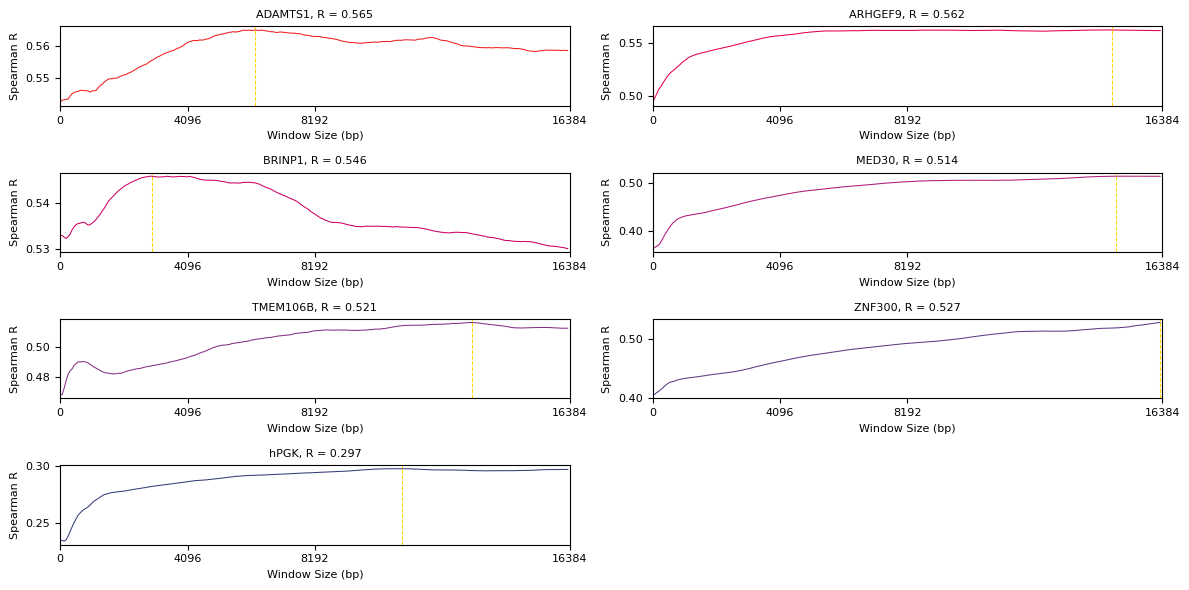

-- Average --
 - Optimal window size = 11355
 - Spearman R at 4kb = 0.482
 - Spearman R at 8kb = 0.495


In [71]:
#Make plots for H3K4me3 window correlations
_ = plot_preds_corr(preds_h3k4me3, agg_mode='sum_log', save_figs=True, fig_suffix='_H3K4me3_v3')


In [72]:
#Choose global window size(s)

window_sizes = {
    'DNASE'    : 8192,
    'H3K4me3'  : 8192,
    'H3K9ac'   : 8192,
    'H3K36me3' : 8192,
    'H3K79me2' : 8192,
    'H3K9me3'  : 8192,
    'H3K27me3' : 8192,
}


In [73]:
from matplotlib.ticker import FormatStrFormatter

#Function to plot average predicted coverage signal per distinct promoter
def plot_mean_preds(preds_sub_folds, window_size=1024, save_figs=False, fig_suffix='_default') :
    
    #Rows and columns for promoter types
    nrows, ncols = 4, 2
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12,6))
    
    #Get average coverage track across folds
    preds_sub = np.mean(preds_sub_folds, axis=1)[:, 512:-512]

    #Loop over promoters
    pi = 0
    for ri in range(nrows) :
        for ci in range(ncols) :
            if pi < len(promoters) :
                
                #Calculate average coverage predictions
                prom_mid = promoter_center[promoters[pi]]
                prom_mask = promoters_mask[promoters[pi]]
                prom_preds = np.log1p(preds_sub[prom_mask,:])
                prom_preds = prom_preds.mean(axis=0)
                
                axs[ri,ci].plot(prom_preds, linewidth=0.75, color=promoter_colors[pi], linestyle='-')
                
                plt.sca(axs[ri,ci])
                
                plt.axvline(x=(prom_mid - 1024)-(window_size // 32) // 2 + 512, linewidth=0.75, color='black', linestyle='--')
                plt.axvline(x=(prom_mid - 1024)+(window_size // 32) // 2 + 512, linewidth=0.75, color='black', linestyle='--')
                
                plt.xlim(0, 1024)
                
                plt.xticks([0, 512, 1024], [-512*32, 0, 512*32], fontsize=8)
                plt.yticks(fontsize=8)
                
                plt.xlabel("Distance from Insertion Site (bp)", fontsize=8)
                plt.ylabel("Signal (log)", fontsize=8)
                
                plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                
                plt.title(promoters[pi], fontsize=8)
            
            else :
                plt.sca(axs[ri,ci])
                plt.axis('off')
            
            pi += 1

    plt.tight_layout()
    
    if save_figs :
        plt.savefig("TRIP_v2_avg_pred" + fig_suffix + ".png", dpi=600, transparent=False)
        plt.savefig("TRIP_v2_avg_pred" + fig_suffix + ".eps")
    
    plt.show()


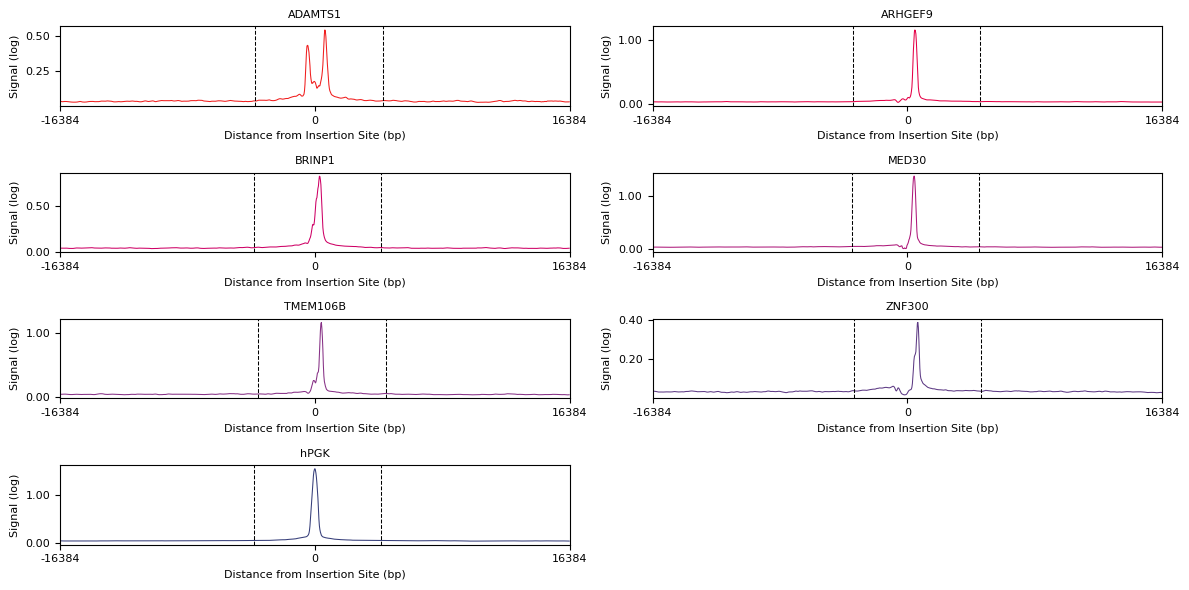

In [74]:
#Make plots for average DNase prediction
plot_mean_preds(preds_dnase, window_size=window_sizes['DNASE'], save_figs=True, fig_suffix='_DNASE_v3')


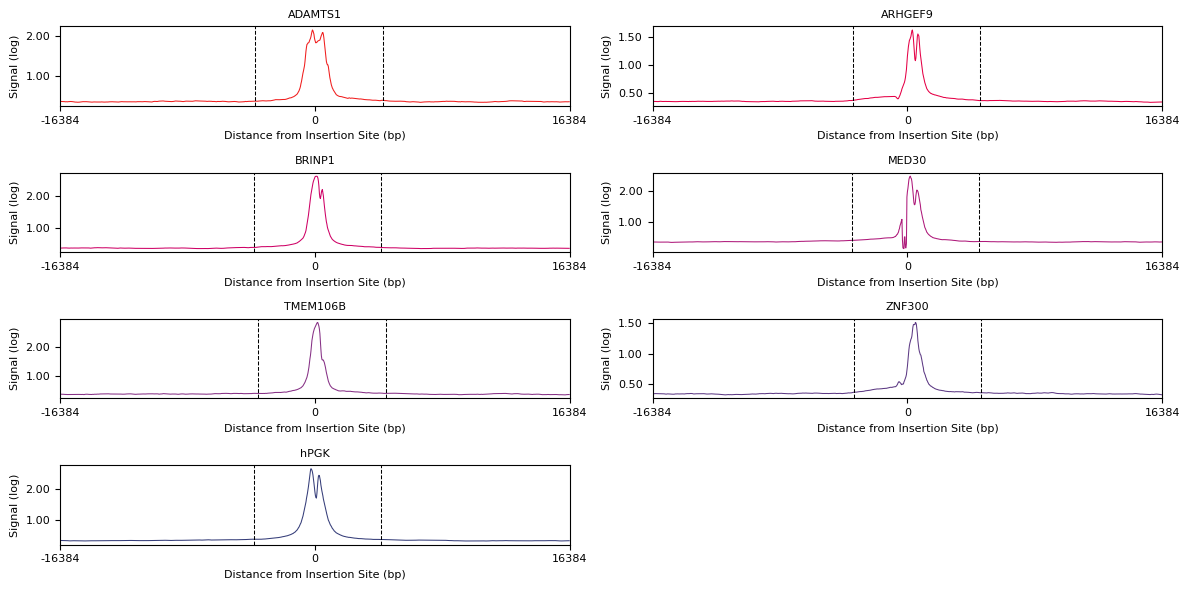

In [75]:
#Make plots for average H3K4me3 prediction
plot_mean_preds(preds_h3k4me3, window_size=window_sizes['H3K4me3'], save_figs=True, fig_suffix='_H3K4me3_v3')


In [76]:
from matplotlib.ticker import FormatStrFormatter

#Function to plot scatter plots between aggregated signal and measured expression
def plot_preds_scatter(preds_sub_folds, window_size, agg_mode='sum_log', save_figs=False, fig_suffix='_default'):
    
    #Rows and columns for promoter types
    nrows, ncols = 3, 3
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12))
    
    #Get average coverage track across folds
    preds_sub = np.mean(preds_sub_folds, axis=1)

    pi = 0
    
    #Loop over promoters
    for ri in range(nrows) :
        for ci in range(ncols) :
            if pi < len(promoters) :
                
                #Get promoter masks, midpoints, measured expression values and measured DamID
                prom_mask = promoters_mask[promoters[pi]]
                prom_mid = promoter_center[promoters[pi]]
                prom_expr = None
                if 'log' in agg_mode and 'log1p' not in agg_mode :
                    prom_expr = np.log(promoters_df[promoters[pi]].expression.values + 1e-6)
                elif 'log1p' in agg_mode :
                    prom_expr = np.log1p(promoters_df[promoters[pi]].expression.values)
                prom_damid = promoters_df[promoters[pi]].LMNB1_DamID.values
                
                #Calculate aggregated signal value
                prom_ext = (window_size // 32) // 2
                prom_preds = np.log1p(preds_sub[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext]).mean(axis=1)
                
                prom_preds = None
                if agg_mode == 'sum_log' :
                    prom_preds = np.log(preds_sub[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext].sum(axis=1) + 1e-6)
                elif agg_mode == 'log_mean' :
                    prom_preds = np.log(preds_sub[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext] + 1e-6).mean(axis=1)
                elif agg_mode == 'sum_log1p' :
                    prom_preds = np.log1p(preds_sub[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext].sum(axis=1))
                elif agg_mode == 'log1p_mean' :
                    prom_preds = np.log1p(preds_sub[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext]).mean(axis=1)
                
                r_pred = spearmanr(prom_preds, prom_expr)[0]
                r_damid = spearmanr(prom_damid, prom_expr)[0]
                
                vmin = np.quantile(prom_damid, q=0.02)
                vmax = np.quantile(prom_damid, q=0.98)

                axs[ri,ci].scatter(prom_preds, prom_expr, c=prom_damid, cmap='Reds', vmin=vmin, vmax=vmax, alpha=0.9, s=6)
                
                plt.sca(axs[ri,ci])
                
                plt.xticks(fontsize=8)
                plt.yticks(fontsize=8)
                
                plt.xlabel("Prediction [" + fig_suffix[1:] + "] (log)", fontsize=8)
                plt.ylabel("Expression (log)", fontsize=8)
                
                plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                
                plt.title(promoters[pi] + "\nR = " + str(round(r_pred, 3)) + ", R (DamID) = " + str(round(r_damid, 3)), fontsize=8)
                
            else :
                plt.sca(axs[ri,ci])
                plt.axis('off')
            
            pi += 1

    plt.tight_layout()
    
    if save_figs :
        plt.savefig("TRIP_v2_scatter" + fig_suffix + ".png", dpi=600, transparent=False)
        plt.savefig("TRIP_v2_scatter" + fig_suffix + ".eps")
    
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


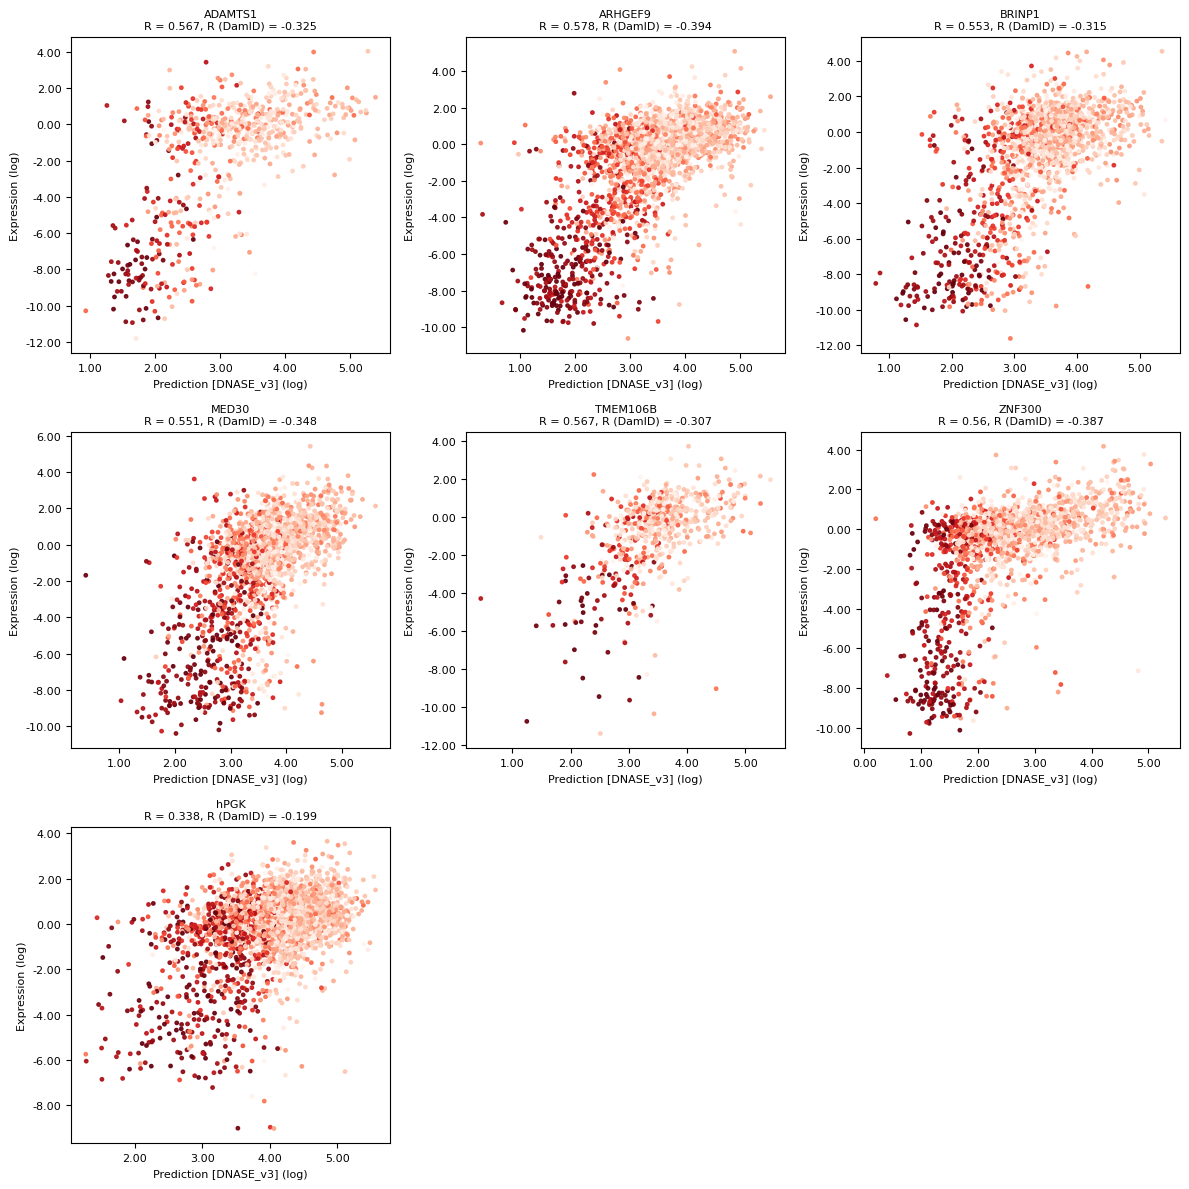

In [77]:
#Make DNase scatter plots
plot_preds_scatter(preds_dnase, window_size=window_sizes['DNASE'], agg_mode='sum_log', save_figs=True, fig_suffix='_DNASE_v3')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


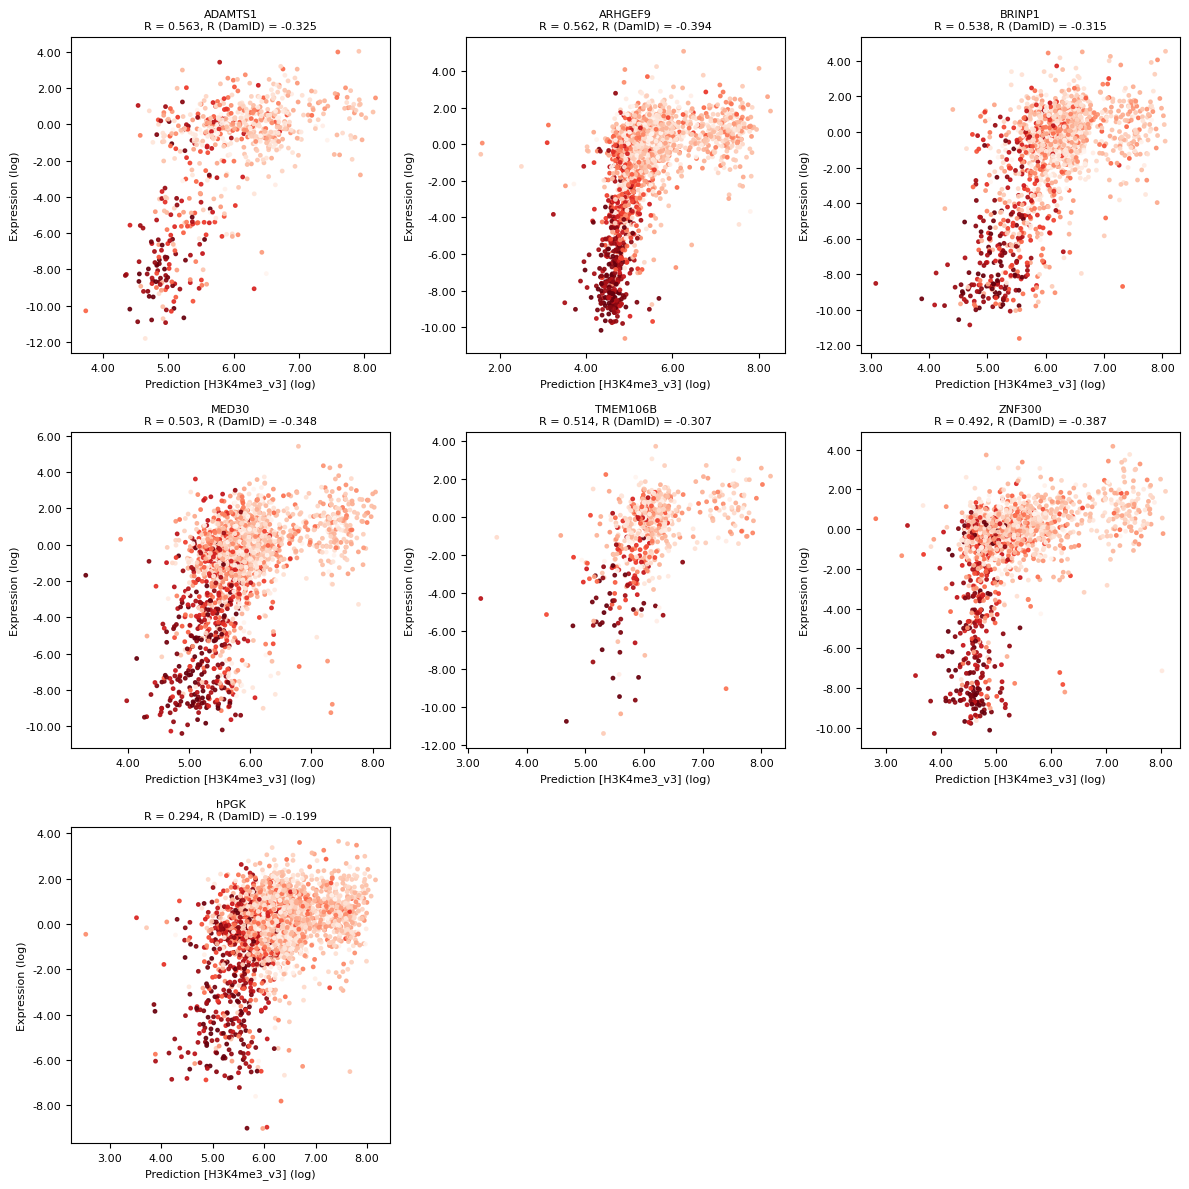

In [78]:
#Make H3K4me3 scatter plots
plot_preds_scatter(preds_h3k4me3, window_size=window_sizes['H3K4me3'], agg_mode='sum_log', save_figs=True, fig_suffix='_H3K4me3_v3')


In [79]:
#Function to aggregate signal in window with various transforms
def _aggr_signal(pi, preds, ext, agg_mode, prom_mask, prom_mid) :
    
    #Aggregate feature
    prom_ext = ext
    if agg_mode == 'sum_log' :
        prom_preds = np.log(np.mean(preds, axis=1)[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext].sum(axis=1) + 1e-6)
    elif agg_mode == 'log_mean' :
        prom_preds = np.log(np.mean(preds, axis=1)[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext] + 1e-6).mean(axis=1)
    elif agg_mode == 'sum_log1p' :
        prom_preds = np.log1p(np.mean(preds, axis=1)[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext].sum(axis=1))
    elif agg_mode == 'log1p_mean' :
        prom_preds = np.log1p(np.mean(preds, axis=1)[prom_mask,prom_mid-prom_ext:prom_mid+1+prom_ext]).mean(axis=1)
    
    return prom_preds

#Function to generate an aggregated feature dataframe for a specific promoter
def make_df_pi(pi, agg_mode='sum_log') :
    
    #Get measured expression of promoter
    prom_expr = None
    if 'log' in agg_mode and 'log1p' not in agg_mode :
        prom_expr = np.log(promoters_df[promoters[pi]].expression.values + 1e-6)
    elif 'log1p' in agg_mode :
        prom_expr = np.log1p(promoters_df[promoters[pi]].expression.values)
    
    #Get measured DamID
    prom_damid = promoters_df[promoters[pi]].LMNB1_DamID.values
    
    #Create feature dataframe
    prom_ols_df = pd.DataFrame({'expression': prom_expr, 'damid': prom_damid})
    
    #Get row masks and promoter signal midpoint
    prom_mask = promoters_mask[promoters[pi]]
    prom_mid = promoter_center[promoters[pi]]
    
    #Aggregate DNase feature
    prom_ols_df['dnase'] = _aggr_signal(pi, preds_dnase, (window_sizes['DNASE'] // 32) // 2, agg_mode, prom_mask, prom_mid)
    
    #Aggregate H3K4me3 feature
    prom_ols_df['h3k4me3'] = _aggr_signal(pi, preds_h3k4me3, (window_sizes['H3K4me3'] // 32) // 2, agg_mode, prom_mask, prom_mid)
    
    #Aggregate H3K9ac feature
    prom_ols_df['h3k9ac'] = _aggr_signal(pi, preds_h3k9ac, (window_sizes['H3K9ac'] // 32) // 2, agg_mode, prom_mask, prom_mid)
    
    #Aggregate H3K9ac feature
    prom_ols_df['h3k36me3'] = _aggr_signal(pi, preds_h3k36me3, (window_sizes['H3K9ac'] // 32) // 2, agg_mode, prom_mask, prom_mid)

    #Aggregate H3K79me2 feature
    prom_ols_df['h3k79me2'] = _aggr_signal(pi, preds_h3k79me2, (window_sizes['H3K79me2'] // 32) // 2, agg_mode, prom_mask, prom_mid)
    
    #Aggregate H3K9me3 feature
    prom_ols_df['h3k9me3'] = _aggr_signal(pi, preds_h3k9me3, (window_sizes['H3K9me3'] // 32) // 2, agg_mode, prom_mask, prom_mid)
    
    #Aggregate H3K27me3 feature
    prom_ols_df['h3k27me3'] = _aggr_signal(pi, preds_h3k27me3, (window_sizes['H3K27me3'] // 32) // 2, agg_mode, prom_mask, prom_mid)
    
    return prom_ols_df


n = 2558


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


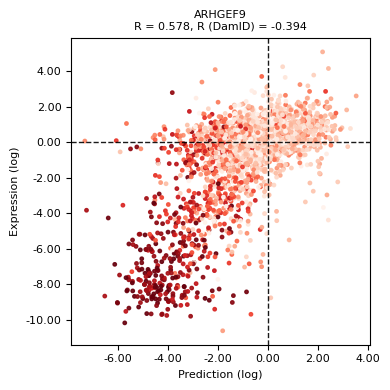

In [80]:
#Linearly regress DNase feature to predict measured expression

save_figs = True
fig_suffix = '_DNASE_v3'

#Choose promoter
pi = 1

#Get feature dataframe
prom_df = make_df_pi(pi)

print("n = " + str(len(prom_df)))

#Make regression feature matrix
x = np.concatenate([
    np.array(prom_df['dnase'].values)[:, None],
], axis=1)

#Make response variable
y = np.array(prom_df['expression'].values)

#Make baseline predictor (DamID)
bl = np.array(prom_df['damid'].values)

#Perform linear regression
lr = LinearRegression().fit(x, y)
y_pred = lr.predict(x)

#Compute correlation
r_pred = spearmanr(y_pred, y)[0]
r_bl = spearmanr(bl, y)[0]

#Plot best-fit predictions vs measurements
f = plt.figure(figsize=(4, 4))

vmin = np.quantile(bl, q=0.02)
vmax = np.quantile(bl, q=0.98)

plt.scatter(y_pred, y, c=bl, cmap='Reds', vmin=vmin, vmax=vmax, alpha=0.9, s=6)

plt.axhline(y=0., linewidth=1, color='black', linestyle='--', alpha=0.9)
plt.axvline(x=0., linewidth=1, color='black', linestyle='--', alpha=0.9)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Prediction (log)", fontsize=8)
plt.ylabel("Expression (log)", fontsize=8)

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title(promoters[pi] + "\nR = " + str(round(r_pred, 3)) + ", R (DamID) = " + str(round(r_bl, 3)), fontsize=8)

plt.tight_layout()
    
if save_figs :
    plt.savefig("TRIP_v2_regression" + fig_suffix + ".png", dpi=600, transparent=False)
    plt.savefig("TRIP_v2_regression" + fig_suffix + ".eps")

plt.show()


n = 2558


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


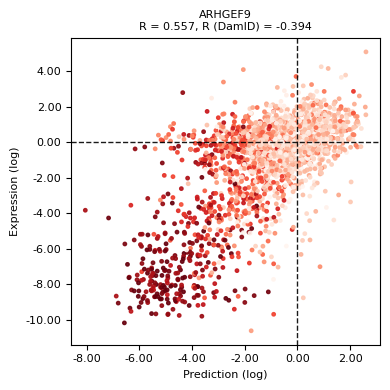

In [81]:
#Linearly regress all aggregated epigenetic features to predict measured expression

save_figs = True
fig_suffix = '_all_v3'

#Choose promoter
pi = 1

#Get feature dataframe
prom_df = make_df_pi(pi)

print("n = " + str(len(prom_df)))

#Make regression feature matrix
x = np.concatenate([
    np.array(prom_df['dnase'].values)[:, None],
    np.array(prom_df['h3k4me3'].values)[:, None],
    np.array(prom_df['h3k9ac'].values)[:, None],
    np.array(prom_df['h3k36me3'].values)[:, None],
    np.array(prom_df['h3k79me2'].values)[:, None],
    np.array(prom_df['h3k9me3'].values)[:, None],
    np.array(prom_df['h3k27me3'].values)[:, None],
], axis=1)

#Make response variable
y = np.array(prom_df['expression'].values)

#Make baseline predictor (DamID)
bl = np.array(prom_df['damid'].values)

#Perform linear regression
lr = LinearRegression().fit(x, y)
y_pred = lr.predict(x)

#Compute correlation
r_pred = spearmanr(y_pred, y)[0]
r_bl = spearmanr(bl, y)[0]

#Plot best-fit predictions vs measurements
f = plt.figure(figsize=(4, 4))

vmin = np.quantile(bl, q=0.02)
vmax = np.quantile(bl, q=0.98)

plt.scatter(y_pred, y, c=bl, cmap='Reds', vmin=vmin, vmax=vmax, alpha=0.9, s=6)

plt.axhline(y=0., linewidth=1, color='black', linestyle='--', alpha=0.9)
plt.axvline(x=0., linewidth=1, color='black', linestyle='--', alpha=0.9)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlabel("Prediction (log)", fontsize=8)
plt.ylabel("Expression (log)", fontsize=8)

plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title(promoters[pi] + "\nR = " + str(round(r_pred, 3)) + ", R (DamID) = " + str(round(r_bl, 3)), fontsize=8)

plt.tight_layout()
    
if save_figs :
    plt.savefig("TRIP_v2_regression" + fig_suffix + ".png", dpi=600, transparent=False)
    plt.savefig("TRIP_v2_regression" + fig_suffix + ".eps")

plt.show()


In [105]:
#Linearly regress DNase feature to predict measured expression (cross-validation)

n_folds = 20

rp_mean = []
rp_mean_bl = []

rs_mean = []
rs_mean_bl = []

#Loop over promoters
for pi in range(len(promoters)) :
    
    print(promoters[pi])

    #Get feature dataframe
    prom_df = make_df_pi(pi)

    n = len(prom_df)
    print(" - n = " + str(n))

    #Make response variable
    y = np.array(prom_df['expression'].values)

    #Make baseline predictor (DamID)
    bl = np.array(prom_df['damid'].values)

    kf = KFold(n_splits=n_folds)

    rp_test_preds = []
    rp_test_bls = []

    rs_test_preds = []
    rs_test_bls = []

    #Loop over folds
    for fold_ix, [train_index, test_index] in enumerate(kf.split(np.arange(n, dtype='int32'))) :

        #Make regression feature matrix
        x = np.concatenate([
            np.array(prom_df['dnase'].values)[:, None],
        ], axis=1)

        #Make train/test splits
        x_train = x[train_index, ...]
        y_train = y[train_index]

        x_test = x[test_index, ...]
        y_test = y[test_index, ...]
        bl_test = bl[test_index, ...]

        #Perform linear regression
        lr = LinearRegression().fit(x_train, y_train)
        y_test_pred = lr.predict(x_test)

        #Compute correlations
        rp_test_preds.append(pearsonr(y_test_pred, y_test)[0])
        rp_test_bls.append(pearsonr(bl_test, y_test)[0])
        
        rs_test_preds.append(spearmanr(y_test_pred, y_test)[0])
        rs_test_bls.append(spearmanr(bl_test, y_test)[0])

    rp_test_pred = np.array(rp_test_preds)
    rp_test_bl = np.array(rp_test_bls)

    rs_test_pred = np.array(rs_test_preds)
    rs_test_bl = np.array(rs_test_bls)
    
    rp_mean.append(np.mean(rp_test_pred))
    rp_mean_bl.append(np.mean(rp_test_bl))
    
    rs_mean.append(np.mean(rs_test_pred))
    rs_mean_bl.append(np.mean(rs_test_bl))
    
    print("Mean Pearson R = " + str(round(np.mean(rp_test_pred), 3)))
    print("Mean Pearson R = " + str(round(np.mean(rp_test_bl), 3)) + " (DamID)")
    print("Mean Spearman R = " + str(round(np.mean(rs_test_pred), 3)))
    print("Mean Spearman R = " + str(round(np.mean(rs_test_bl), 3)) + " (DamID)")
    print("")

rp_mean = np.array(rp_mean)
rp_mean_bl = np.array(rp_mean_bl)

rs_mean = np.array(rs_mean)
rs_mean_bl = np.array(rs_mean_bl)

print("rp_mean.shape = " + str(rp_mean.shape))
print("rp_mean_bl.shape = " + str(rp_mean_bl.shape))

print("rs_mean.shape = " + str(rs_mean.shape))
print("rs_mean_bl.shape = " + str(rs_mean_bl.shape))


ADAMTS1
 - n = 676
Mean Pearson R = 0.625
Mean Pearson R = -0.518 (DamID)
Mean Spearman R = 0.551
Mean Spearman R = -0.313 (DamID)

ARHGEF9
 - n = 2558
Mean Pearson R = 0.658
Mean Pearson R = -0.64 (DamID)
Mean Spearman R = 0.58
Mean Spearman R = -0.393 (DamID)

BRINP1
 - n = 1550
Mean Pearson R = 0.635
Mean Pearson R = -0.522 (DamID)
Mean Spearman R = 0.553
Mean Spearman R = -0.313 (DamID)

MED30
 - n = 2172
Mean Pearson R = 0.592
Mean Pearson R = -0.525 (DamID)
Mean Spearman R = 0.547
Mean Spearman R = -0.346 (DamID)

TMEM106B
 - n = 628
Mean Pearson R = 0.556
Mean Pearson R = -0.484 (DamID)
Mean Spearman R = 0.536
Mean Spearman R = -0.279 (DamID)

ZNF300
 - n = 1689
Mean Pearson R = 0.537
Mean Pearson R = -0.556 (DamID)
Mean Spearman R = 0.555
Mean Spearman R = -0.383 (DamID)

hPGK
 - n = 3504
Mean Pearson R = 0.455
Mean Pearson R = -0.389 (DamID)
Mean Spearman R = 0.337
Mean Spearman R = -0.199 (DamID)

rp_mean.shape = (7,)
rp_mean_bl.shape = (7,)
rs_mean.shape = (7,)
rs_mean_bl.sh

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


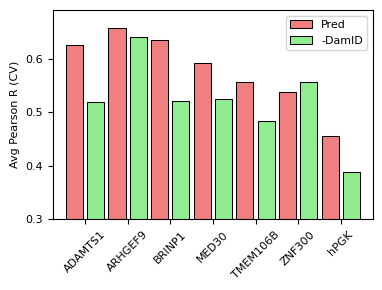

In [106]:
#Summarize average CV Pearson R vs baseline (DamID) in a bar chart

save_figs = True
fig_suffix = '_DNASE_v3'

f = plt.figure(figsize=(4, 3))

plt.bar(np.arange(len(rp_mean)) * 2, rp_mean, color='lightcoral', edgecolor='black', linewidth=0.75, label='Pred')
plt.bar(np.arange(len(rp_mean_bl)) * 2 + 1, -rp_mean_bl, color='lightgreen', edgecolor='black', linewidth=0.75, label='-DamID')

plt.xticks(np.arange(len(promoters)) * 2 + 0.5, promoters, rotation=45, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel("Avg Pearson R (CV)", fontsize=8)

plt.xlim(-1.0, 2 * len(promoters))
plt.ylim(.3)

plt.legend(fontsize=8)

plt.tight_layout()
    
if save_figs :
    plt.savefig("TRIP_v2_cv_pearson_bar" + fig_suffix + ".png", dpi=600, transparent=False)
    plt.savefig("TRIP_v2_cv_pearson_bar" + fig_suffix + ".eps")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


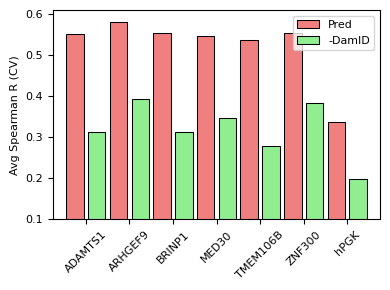

In [107]:
#Summarize average CV Spearman R vs baseline (DamID) in a bar chart

save_figs = True
fig_suffix = '_DNASE_v3'

f = plt.figure(figsize=(4, 3))

plt.bar(np.arange(len(rs_mean)) * 2, rs_mean, color='lightcoral', edgecolor='black', linewidth=0.75, label='Pred')
plt.bar(np.arange(len(rs_mean_bl)) * 2 + 1, -rs_mean_bl, color='lightgreen', edgecolor='black', linewidth=0.75, label='-DamID')

plt.xticks(np.arange(len(promoters)) * 2 + 0.5, promoters, rotation=45, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel("Avg Spearman R (CV)", fontsize=8)

plt.xlim(-1.0, 2 * len(promoters))
plt.ylim(.1)

plt.legend(fontsize=8)

plt.tight_layout()

if save_figs :
    plt.savefig("TRIP_v2_cv_spearman_bar" + fig_suffix + ".png", dpi=600, transparent=False)
    plt.savefig("TRIP_v2_cv_spearman_bar" + fig_suffix + ".eps")

plt.show()


In [108]:
#Linearly regress all aggregated epigenetic features to predict measured expression (cross-validation)

n_folds = 20

rp_mean = []
rp_mean_bl = []

rs_mean = []
rs_mean_bl = []

#Loop over promoters
for pi in range(len(promoters)) :
    
    print(promoters[pi])

    #Get feature dataframe
    prom_df = make_df_pi(pi)

    n = len(prom_df)
    print(" - n = " + str(n))

    #Make response variable
    y = np.array(prom_df['expression'].values)

    #Make baseline predictor (DamID)
    bl = np.array(prom_df['damid'].values)

    kf = KFold(n_splits=n_folds)

    rp_test_preds = []
    rp_test_bls = []

    rs_test_preds = []
    rs_test_bls = []

    #Loop over folds
    for fold_ix, [train_index, test_index] in enumerate(kf.split(np.arange(n, dtype='int32'))) :

        #Make regression feature matrix
        x = np.concatenate([
            np.array(prom_df['dnase'].values)[:, None],
            np.array(prom_df['h3k4me3'].values)[:, None],
            np.array(prom_df['h3k9ac'].values)[:, None],
            np.array(prom_df['h3k36me3'].values)[:, None],
            np.array(prom_df['h3k79me2'].values)[:, None],
            np.array(prom_df['h3k9me3'].values)[:, None],
            np.array(prom_df['h3k27me3'].values)[:, None],
        ], axis=1)

        #Make train/test splits
        x_train = x[train_index, ...]
        y_train = y[train_index]

        x_test = x[test_index, ...]
        y_test = y[test_index, ...]
        bl_test = bl[test_index, ...]

        #Perform linear regression
        lr = LinearRegression().fit(x_train, y_train)
        y_test_pred = lr.predict(x_test)

        #Compute correlations
        rp_test_preds.append(pearsonr(y_test_pred, y_test)[0])
        rp_test_bls.append(pearsonr(bl_test, y_test)[0])
        
        rs_test_preds.append(spearmanr(y_test_pred, y_test)[0])
        rs_test_bls.append(spearmanr(bl_test, y_test)[0])

    rp_test_pred = np.array(rp_test_preds)
    rp_test_bl = np.array(rp_test_bls)

    rs_test_pred = np.array(rs_test_preds)
    rs_test_bl = np.array(rs_test_bls)
    
    rp_mean.append(np.mean(rp_test_pred))
    rp_mean_bl.append(np.mean(rp_test_bl))
    
    rs_mean.append(np.mean(rs_test_pred))
    rs_mean_bl.append(np.mean(rs_test_bl))
    
    print("Mean Pearson R = " + str(round(np.mean(rp_test_pred), 3)))
    print("Mean Pearson R = " + str(round(np.mean(rp_test_bl), 3)) + " (DamID)")
    print("Mean Spearman R = " + str(round(np.mean(rs_test_pred), 3)))
    print("Mean Spearman R = " + str(round(np.mean(rs_test_bl), 3)) + " (DamID)")
    print("")

rp_mean = np.array(rp_mean)
rp_mean_bl = np.array(rp_mean_bl)

rs_mean = np.array(rs_mean)
rs_mean_bl = np.array(rs_mean_bl)

print("rp_mean.shape = " + str(rp_mean.shape))
print("rp_mean_bl.shape = " + str(rp_mean_bl.shape))

print("rs_mean.shape = " + str(rs_mean.shape))
print("rs_mean_bl.shape = " + str(rs_mean_bl.shape))


ADAMTS1
 - n = 676
Mean Pearson R = 0.644
Mean Pearson R = -0.518 (DamID)
Mean Spearman R = 0.55
Mean Spearman R = -0.313 (DamID)

ARHGEF9
 - n = 2558
Mean Pearson R = 0.687
Mean Pearson R = -0.64 (DamID)
Mean Spearman R = 0.557
Mean Spearman R = -0.393 (DamID)

BRINP1
 - n = 1550
Mean Pearson R = 0.646
Mean Pearson R = -0.522 (DamID)
Mean Spearman R = 0.571
Mean Spearman R = -0.313 (DamID)

MED30
 - n = 2172
Mean Pearson R = 0.615
Mean Pearson R = -0.525 (DamID)
Mean Spearman R = 0.579
Mean Spearman R = -0.346 (DamID)

TMEM106B
 - n = 628
Mean Pearson R = 0.559
Mean Pearson R = -0.484 (DamID)
Mean Spearman R = 0.552
Mean Spearman R = -0.279 (DamID)

ZNF300
 - n = 1689
Mean Pearson R = 0.589
Mean Pearson R = -0.556 (DamID)
Mean Spearman R = 0.532
Mean Spearman R = -0.383 (DamID)

hPGK
 - n = 3504
Mean Pearson R = 0.488
Mean Pearson R = -0.389 (DamID)
Mean Spearman R = 0.377
Mean Spearman R = -0.199 (DamID)

rp_mean.shape = (7,)
rp_mean_bl.shape = (7,)
rs_mean.shape = (7,)
rs_mean_bl.sh

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


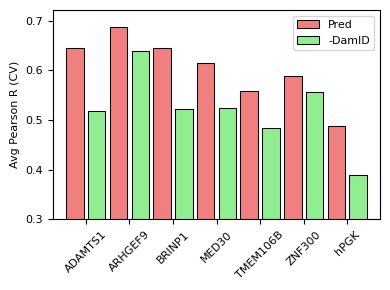

In [109]:
#Summarize average CV Pearson R vs baseline (DamID) in a bar chart

save_figs = True
fig_suffix = '_all_v3'

f = plt.figure(figsize=(4, 3))

plt.bar(np.arange(len(rp_mean)) * 2, rp_mean, color='lightcoral', edgecolor='black', linewidth=0.75, label='Pred')
plt.bar(np.arange(len(rp_mean_bl)) * 2 + 1, -rp_mean_bl, color='lightgreen', edgecolor='black', linewidth=0.75, label='-DamID')

plt.xticks(np.arange(len(promoters)) * 2 + 0.5, promoters, rotation=45, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel("Avg Pearson R (CV)", fontsize=8)

plt.xlim(-1.0, 2 * len(promoters))
plt.ylim(.3)

plt.legend(fontsize=8)

plt.tight_layout()
    
if save_figs :
    plt.savefig("TRIP_v2_cv_pearson_bar" + fig_suffix + ".png", dpi=600, transparent=False)
    plt.savefig("TRIP_v2_cv_pearson_bar" + fig_suffix + ".eps")

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


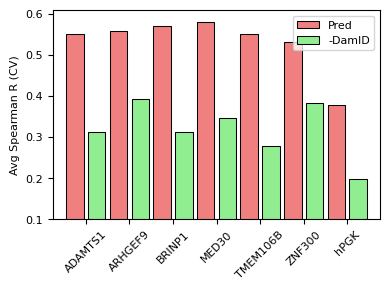

In [110]:
#Summarize average CV Spearman R vs baseline (DamID) in a bar chart

save_figs = True
fig_suffix = '_all_v3'

f = plt.figure(figsize=(4, 3))

plt.bar(np.arange(len(rs_mean)) * 2, rs_mean, color='lightcoral', edgecolor='black', linewidth=0.75, label='Pred')
plt.bar(np.arange(len(rs_mean_bl)) * 2 + 1, -rs_mean_bl, color='lightgreen', edgecolor='black', linewidth=0.75, label='-DamID')

plt.xticks(np.arange(len(promoters)) * 2 + 0.5, promoters, rotation=45, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel("Avg Spearman R (CV)", fontsize=8)

plt.xlim(-1.0, 2 * len(promoters))
plt.ylim(.1)

plt.legend(fontsize=8)

plt.tight_layout()

if save_figs :
    plt.savefig("TRIP_v2_cv_spearman_bar" + fig_suffix + ".png", dpi=600, transparent=False)
    plt.savefig("TRIP_v2_cv_spearman_bar" + fig_suffix + ".eps")

plt.show()
